In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [3]:
import sys
import os

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import operator
import statsmodels.api as sm
import pickle

utils.reset_seeds(0)
pd.set_option('display.max_columns', 50)

In [79]:
regioon = ['a', 'b', 'c', 'd', 'e']
naabrid = [['b'], ['a','c'], ['b','d'], ['c','e'], ['d']]
kaugemad = [['c'], ['d'], ['a','e'], ['b'], ['c']]

regioonide_combod = list(zip(regioon, naabrid, kaugemad))

with open('ols_model.pkl', 'rb') as f:
    regressioon_mudel = pickle.load(f)
with open('regression_scaler.pkl', 'rb') as f:
    reg_scaler = pickle.load(f)
    
def process_break_points(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)
    # print(data)
    return np.histogram(data[:, 0], bins=regions)[0]

def process_rmse(file_path, regions):
    with open(file_path, 'rb') as f:
        data = np.load(f)

    # splitime andmed vastavalt regionitele jätame välja piirkonnad mis on väiksem ja suurem kui andmete piirid
    r_all = np.split(data, np.searchsorted(data[:, 0], v=regions))[1:-1]
    
    # absoluutsed vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    absoluut_vahed = [np.mean(r[:, 2] - r[:, 3]) for r in r_all]

    # 3. joone keskmine igas piirkonnas
    r3_mean = [np.mean(r[:, 3]) for r in r_all]
    # 2. joone keskmine igas piirkonnas
    r2_mean =  [np.mean(r[:, 2]) for r in r_all]

    # suhtelised vahed joonte 2. ja 3. vahel (keskmine piirkonnas)
    suhtelised_vahed = [absoluut / r_m for absoluut, r_m in zip(absoluut_vahed, r3_mean)]

    return absoluut_vahed, suhtelised_vahed, (r2_mean, r3_mean)
def laisk_nll(y_true, ypredmean, ypredlogvar):
    # tf.reduce_mean(y_pred_var + tf.math.square(y_true - y_pred_mean) / tf.math.exp(y_pred_var))
    return np.mean(ypredmean + (y_true -ypredmean)**2 / np.exp(ypredlogvar))

In [ ]:
# const	-0.0912
# neighbour_raw_mean2	0.5223
# distant_raw_mean2	0.6167
# mse_treeningul	-0.2948
# points_combo	0.9997
# bpoints_combo	0.8915

In [22]:
baasdir = "const_func_uneven_data"
# done train_size = params['train_size']
# done random_seed = params['random_seed']
# done multiplier = params['multiplier']
# done region = ord(params['region'])-65
# fn = params['fn']
# noise_fn=params["noise_fn"]
# reverse_noise = params["reverse_noise"]

In [45]:
df_columns = ['train_size', 'random_seed', 'multiplier', 'region',
              *[f'bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'ext_bpoints_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'abs_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'rel_diff_in_{chr(a)}' for a in range(97, 97+5)],
              *[f'raw_mean2_in_{chr(a)}' for a in range(97, 97+5)],
              #*[f'raw_mean3_in_{chr(a)}' for a in range(97, 97+5)],
              'mse_treeningul',]

In [52]:
nimed = ['my_bpoints', 'neighbour_bpoints', 'distant_bpoints',
       'my_raw_mean2', 'neighbour_raw_mean2', 'distant_raw_mean2',
       'my_points', 'neighbour_points', 'distant_points', 'my_points_m1',
       'my_points_log', 'my_points_logm1', 'neighbour_points_m1',
       'neighbour_points_log', 'neighbour_points_logm1',
       'distant_points_m1', 'distant_points_log', 'distant_points_logm1',
       'mse_treeningul']
maxid = pd.Series([1.36000000e+01, 8.88000000e+00, 8.88000000e+00, 1.32377570e+01,
       7.78445639e+00, 6.64541133e+00, 1.60100000e+03, 1.60100000e+03,
       1.60100000e+03, 1.00000000e+00, 7.37838371e+00, 1.00000000e+00,
       1.00000000e+00, 7.37838371e+00, 1.00000000e+00, 1.00000000e+00,
       7.37838371e+00, 1.00000000e+00, 1.89922188e+01])
minid = pd.Series([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.34958076e-02,
       2.26497686e-01, 2.26497686e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 6.24609619e-04, 0.00000000e+00, 1.19354763e-01,
       6.24609619e-04, 0.00000000e+00, 1.19354763e-01, 6.24609619e-04,
       0.00000000e+00, 1.19354763e-01, 7.06633241e-01]])


In [94]:
uus_df_temp = []
uus_df_cols = ['train_size', 'seed', 'multiplier','region', 'vana_nll', 'uus_nll']
for dirpath, dirs_in_dir, files in os.walk(baasdir):
    if "models" in dirpath:
        continue
    if "plots" in dirpath:
        continue
    if len(files) != 0:
        # print(dirpath)
        head, multiplier_region = os.path.split(dirpath)
        head, seed = os.path.split(head)
        head, train_size = os.path.split(head)
        multiplier, region = float(multiplier_region[:-1]), multiplier_region[-1]
        seed, train_size = int(seed), int(train_size)

        if "sin" in dirpath:
            fn = lambda x:x*np.sin(x)
        else:
            fn = lambda x:0*x
        noise_fn = lambda X: 0.3 * np.random.randn(len(X)) + 0.3 * X * np.random.randn(len(X))
        if "reverse" in dirpath:
            reverse_noise=True
        else:
            reverse_noise=False
        
        bpoints = process_break_points(os.path.join(dirpath, "bpoints.npy"), np.arange(0, 12, 2))
        abs_diff, rel_diff, (raw_mean2, raw_mean3) = process_rmse(os.path.join(dirpath, "rmses.npy"), np.arange(0, 12, 2))
        with open(os.path.join(dirpath, "mses.json"), 'r', encoding="cp1252") as f:
            mses = json.load(f)
            mse_treeningul = mses["mse_treeningul"]
        
       
        with open(os.path.join(dirpath, "y_pred.npy"), 'rb') as f:
            y_preds = np.load(f)


        andmestik = pd.DataFrame(data=[[train_size, seed, multiplier,region, *bpoints, *rel_diff, *raw_mean2, mse_treeningul]], columns=df_columns)

        Xid, yid = [], []
        for r, n, k in regioonide_combod:
            
            X, y = utils.transform_no_scaling(andmestik, r, n, k)
            Xid.append(X)
            yid.append(y) 

        suurX = pd.concat(Xid, ignore_index=True)
        suury = pd.concat(yid, ignore_index=True)
        # print("train_size, seed, multiplier,region")
        # print(train_size, seed, multiplier,region)
        # display(suurX.head())

        uuritavad_col = suurX.columns
        suurX = reg_scaler.transform(suurX,)
        suurX = pd.DataFrame(suurX, columns=uuritavad_col)
        suurX["my_points_combo"] = suurX.my_points * -0.3762 + suurX.my_points_m1 * -3.3876 + suurX.my_points_log * 1.3885 + suurX.my_points_logm1 * 4.0044 + np.ones(shape=suurX.shape[0]) * -1.0568
        suurX["neighbour_points_combo"] = suurX.neighbour_points * -0.3268 + suurX.neighbour_points_m1 * -1.7966 + suurX.neighbour_points_log * 0.7729 + suurX.neighbour_points_logm1 *1.7054 + np.ones(shape=suurX.shape[0]) * -0.5441
        # suurX["distant_points_combo"] = suurX.distant_points * result3.params["distant_points"] + suurX.distant_points_m1 * result3.params["distant_points_m1"] + suurX.distant_points_log * result3.params["distant_points_log"] + suurX.distant_points_logm1 * result3.params["distant_points_logm1"] + np.ones(shape=suurX.shape[0]) * result3.params["const"]
        suurX["points_combo"] = suurX.my_points_combo * 0.8223 + suurX.neighbour_points_combo * 0.2080# + const4 * result4.params["const"]

        suurX["bpoints_combo"] = suurX.my_bpoints * -0.4097 + suurX.neighbour_bpoints * -0.1139 + suurX.distant_bpoints * -0.0604 + np.ones(shape=suurX.shape[0]) * 0.0618

        suurX.drop(['my_bpoints', 'neighbour_bpoints', 'distant_bpoints', 
            'my_points','neighbour_points_combo', 'my_points_combo', 
        'neighbour_points', 'distant_points', 'my_points_m1', 'my_points_log',
        'my_points_logm1', 'neighbour_points_m1', 'neighbour_points_log',
        'neighbour_points_logm1', 'distant_points_m1', 'distant_points_log',
        'distant_points_logm1', ], axis=1, inplace=True)

        y_pred_mean = y_preds[:,0]
        y_pred_logvar = y_preds[:,1]
        a = y_pred_logvar
        y_pred_sd = np.sqrt(np.exp(y_pred_logvar))
        correctors = regressioon_mudel.predict(suurX)
        b = correctors.repeat(y_preds.shape[0]/5)

        x = a / (b+1) # ühik : logvar
        x_sd = np.sqrt(np.exp(x))


        utils.reset_seeds(seed)
        
        X = utils.create_x_train(train_size=train_size, different_place=ord(region)-65, different_multiplier=multiplier)
        X = np.linspace(0,10,1000000)
        if reverse_noise:
            y_true = fn(X) + noise_fn(X[::-1])
        else:
            y_true = fn(X) + noise_fn(X)
        vana = laisk_nll(y_true, y_pred_mean, y_pred_logvar)
        uus = laisk_nll(y_true, y_pred_mean, x_sd)
        uus_df_temp.append([train_size, seed, multiplier,region, vana, uus])

# suurX.head()
df = pd.DataFrame(data=uus_df_temp, columns=uus_df_cols)
df.to_csv("andmed2/improvements.csv", index=False)

In [17]:

df = pd.read_csv("andmed2/improvements.csv")
df.head(30)


,train_size,seed,multiplier,region,vana_nll,uus_nll
0,10,0,0.25,A,5.524463,2.488702
1,10,0,0.25,B,5.677048,2.634620
2,10,0,0.25,C,7.781107,2.913424
3,10,0,0.50,A,6.910061,2.558408
4,10,0,0.50,B,8.671155,3.039126
5,10,0,0.50,C,11.702075,2.922421
6,10,0,1.00,A,88.683474,1.779198
7,10,0,1.00,B,54.365899,1.726060
8,10,0,2.00,A,2.680606,0.254013
9,10,0,2.00,B,2.631596,0.311761


## Test improvements

In [51]:
%ls andmed3

 Volume in drive C is Windows
 Volume Serial Number is EA13-856F

 Directory of c:\Users\troosma\Documents\Ylikool\6. semester\Bakat��\bakatoo\andmed3

09/05/2023  20:48    <DIR>          .
09/05/2023  20:48    <DIR>          ..
08/05/2023  15:13    <DIR>          all_four
09/05/2023  02:16         1,183,947 const_improvement.csv
09/05/2023  02:28         1,184,657 const_reverse_improvement.csv
09/05/2023  02:28         1,169,088 sin_improvement.csv
08/05/2023  15:12        11,419,829 sin_reverse.csv
09/05/2023  02:59         1,157,694 sin_reverse_improvement.csv
09/05/2023  20:48    <DIR>          test
               5 File(s)     16,115,215 bytes
               4 Dir(s)  16,371,359,744 bytes free


In [52]:
dfs = pd.read_csv("andmed3/test/sin_order_improvement.csv")
dfs["type"] = "sin"
dfsr = pd.read_csv("andmed3/test/sin_reverse_improvement.csv")
dfsr["type"] = "sin_reverse"

df = pd.concat([dfs, dfsr], ignore_index=True) # ,

In [53]:
df["improvement"] = df["vana_nll"] -df["uus_nll"]
# df = df[df["improvement"] < 10**7]
# df = df.groupby(['region', 'multiplier', 'train_size', 'type']).mean().reset_index()
df.shape

(9405, 8)

In [58]:
df[(df["improvement"]>0) & (df["vana_nll"]<10)]

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
0,80,53,0.50,A,2.978639,2.885367,sin,0.093272
3,80,53,4.00,E,2.222323,2.146685,sin,0.075637
9,80,53,4.00,D,4.536394,3.862082,sin,0.674311
10,80,53,1.00,D,2.948128,2.065310,sin,0.882818
11,80,53,1.00,E,2.948128,2.065310,sin,0.882818
...,...,...,...,...,...,...,...,...
9013,90,59,0.50,E,3.518425,3.254935,sin_reverse,0.263489
9053,90,50,0.25,C,5.365903,4.045178,sin_reverse,1.320725
9154,90,52,0.50,D,3.886592,3.494116,sin_reverse,0.392476
9158,90,52,0.50,E,5.342068,5.005388,sin_reverse,0.336680


In [56]:
siinus_impr_kokku = df[(df["improvement"] > 0)].value_counts("type")["sin"]+df[(df["improvement"] > 0)].value_counts("type")["sin_reverse"]
siinuseid_kokku = df.value_counts("type")["sin"]+df.value_counts("type")["sin_reverse"]

print(siinus_impr_kokku/siinuseid_kokku)

0.18330675172780436


In [59]:
print(df[df["improvement"] > 0].shape[0] / df.shape[0])

0.18330675172780436


## Improvements

In [24]:
dfs = pd.read_csv("andmed3/sin_improvement.csv")
dfs["type"] = "sin"
dfsr = pd.read_csv("andmed3/sin_reverse_improvement.csv")
dfsr["type"] = "sin_reverse"
dfc = pd.read_csv("andmed3/const_improvement.csv")
dfc["type"] = "const"
dfcr = pd.read_csv("andmed3/const_reverse_improvement.csv")
dfcr["type"] = "const_reverse"
df = pd.concat([dfs, dfsr, dfc, dfcr], ignore_index=True) # ,

In [28]:
df["improvement"] = df["vana_nll"] -df["uus_nll"]
# df = df[df["improvement"] < 10**7]
# df = df.groupby(['region', 'multiplier', 'train_size', 'type']).mean().reset_index()
df.shape

(94620, 8)

In [29]:
df.head()

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
0,80,34,0.50,A,2.882363,3.684691,sin,-0.802328
1,80,34,0.25,A,2.738229,3.001895,sin,-0.263666
2,80,34,0.25,B,2.487368,2.687741,sin,-0.200372
3,80,34,4.00,E,2.744050,2.563969,sin,0.180080
4,80,34,4.00,A,2.726883,3.295301,sin,-0.568417


In [31]:
df[df["improvement"]>0]

,train_size,seed,multiplier,region,vana_nll,uus_nll,type,improvement
3,80,34,4.00,E,2.744050,2.563969,sin,0.180080
7,80,34,2.00,E,1.702124,1.662552,sin,0.039572
27,80,37,0.25,B,2.656551,1.733434,sin,0.923117
28,80,37,4.00,E,3.194785,2.706750,sin,0.488036
35,80,37,1.00,D,6.409923,5.024999,sin,1.384925
...,...,...,...,...,...,...,...,...
90741,20,42,1.00,B,4629.820770,4512.552562,const_reverse,117.268209
90744,20,42,1.00,C,4629.820770,4512.552562,const_reverse,117.268209
94188,10,16,0.25,C,13530.608933,12827.901954,const_reverse,702.706978
94190,10,16,0.25,D,652.220954,603.495403,const_reverse,48.725551


In [37]:
print(df[(df["improvement"] < 0)].shape)
print(df[(df["improvement"] > 0)].shape)
df[(df["improvement"] > 0)].shape[0] / df.shape[0]

(85872, 8)
(8217, 8)


0.0868421052631579

In [40]:
df[(df["improvement"] > 0)].value_counts("type")

type
sin              6457
sin_reverse      1701
const              49
const_reverse      10
dtype: int64

AttributeError: 'str' object has no attribute 'isin'

In [47]:
siinus_impr_kokku = df[(df["improvement"] > 0)].value_counts("type")["sin"]+df[(df["improvement"] > 0)].value_counts("type")["sin_reverse"]
siinuseid_kokku = df.value_counts("type")["sin"]+df.value_counts("type")["sin_reverse"]

print(siinus_impr_kokku/siinuseid_kokku)

0.17313242784380306


23370

In [13]:
multi_kaudu = df[df["type"]=="const_reverse"].groupby(['multiplier']).mean().reset_index()
multi_kaudu

C:\Users\troosma\AppData\Local\Temp\ipykernel_28756\447603749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  multi_kaudu = df[df["type"]=="const_reverse"].groupby(['multiplier']).mean().reset_index()


,multiplier,train_size,seed,vana_nll,uus_nll,improvement
0,0.25,300.0,24.5,350.007581,559.740388,-209.732806
1,0.50,300.0,24.5,262.598039,396.085819,-133.487780
2,1.00,300.0,24.5,148.925758,221.637269,-72.711511
3,2.00,300.0,24.5,229.518691,339.489768,-109.971077
4,4.00,300.0,24.5,326.839197,482.183191,-155.343994


In [14]:
reg_kaudu = df.groupby(['region']).mean().reset_index()
reg_kaudu

C:\Users\troosma\AppData\Local\Temp\ipykernel_28756\3630790157.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reg_kaudu = df.groupby(['region']).mean().reset_index()


,region,train_size,seed,multiplier,vana_nll,uus_nll,improvement
0,A,300.0,24.5,1.55,1.350397e+02,1.955779e+02,-6.140571e+01
1,B,300.0,24.5,1.55,8.280821e+01,1.198437e+02,-3.772462e+01
2,C,300.0,24.5,1.55,1.177127e+02,1.664322e+02,-4.893056e+01
3,D,300.0,24.5,1.55,1.060743e+02,1.507235e+02,-4.513983e+01
4,E,300.0,24.5,1.55,2.539723e+08,4.616458e+08,-2.059870e+08


In [15]:
train_size_kaudu = df.groupby(['train_size']).mean().reset_index()
train_size_kaudu

C:\Users\troosma\AppData\Local\Temp\ipykernel_28756\9094199.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_size_kaudu = df.groupby(['train_size']).mean().reset_index()


,train_size,seed,multiplier,vana_nll,uus_nll,improvement
0,10,24.5,1.55,9.650952e+08,1.796827e+09,-8.017467e+08
1,20,24.5,1.55,4.497950e+02,6.408474e+02,-1.866860e+02
2,30,24.5,1.55,2.726143e+02,3.751613e+02,-1.001802e+02
3,40,24.5,1.55,2.705364e+02,3.934278e+02,-1.212365e+02
4,50,24.5,1.55,6.259596e+01,8.437924e+01,-2.136955e+01
5,60,24.5,1.55,1.974967e+01,2.555948e+01,-5.888145e+00
6,70,24.5,1.55,1.835221e+02,2.742453e+02,-8.955541e+01
7,80,24.5,1.55,1.051518e+01,1.488712e+01,-4.316806e+00
8,90,24.5,1.55,2.855330e+01,4.084971e+01,-1.218674e+01
9,100,24.5,1.55,7.638687e+00,1.011054e+01,-2.426422e+00


C:\Users\troosma\AppData\Local\Temp\ipykernel_28756\3443604373.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mult_ja_reg = df.groupby(['multiplier', 'region']).mean().reset_index()


<AxesSubplot: xlabel='region', ylabel='multiplier'>

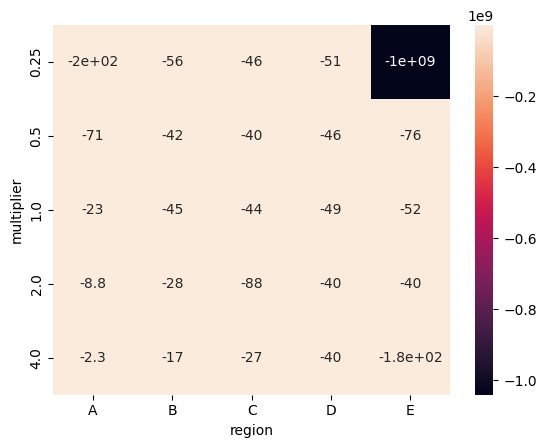

In [16]:
mult_ja_reg = df.groupby(['multiplier', 'region']).mean().reset_index()
mult_ja_reg = mult_ja_reg.pivot_table(index="multiplier", columns="region", values="improvement")
sns.heatmap(data=mult_ja_reg, annot=True)
# mult_ja_reg

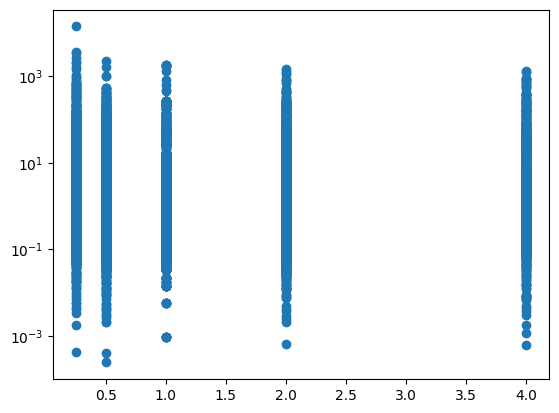

In [17]:
plt.yscale("log")
plt.scatter(df["multiplier"], df["improvement"])

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
train_size,71250.0,3.000000e+02,4.764071e+02,1.000000e+01,50.000000,100.000000,250.000000,2.000000e+03
seed,71250.0,2.450000e+01,1.443097e+01,0.000000e+00,12.000000,24.500000,37.000000,4.900000e+01
multiplier,71250.0,1.550000e+00,1.363828e+00,2.500000e-01,0.500000,1.000000,2.000000,4.000000e+00
vana_nll,71250.0,5.079455e+07,1.355840e+10,-4.222584e+00,1.140485,1.791951,3.791101,3.619102e+12
uus_nll,70796.0,9.230841e+07,2.456093e+10,-1.027709e+01,1.928955,2.603641,4.467977,6.535053e+12
improvement,70796.0,-4.118813e+07,1.095912e+10,-2.915950e+12,-1.209368,-0.810625,-0.645438,1.412518e+04
